<a href="https://colab.research.google.com/github/sonyerim/BK21/blob/main/src/CH10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 10.5.1 VARMA 모델을 사용하여 realdpi와 realcons 예측하기

In [3]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


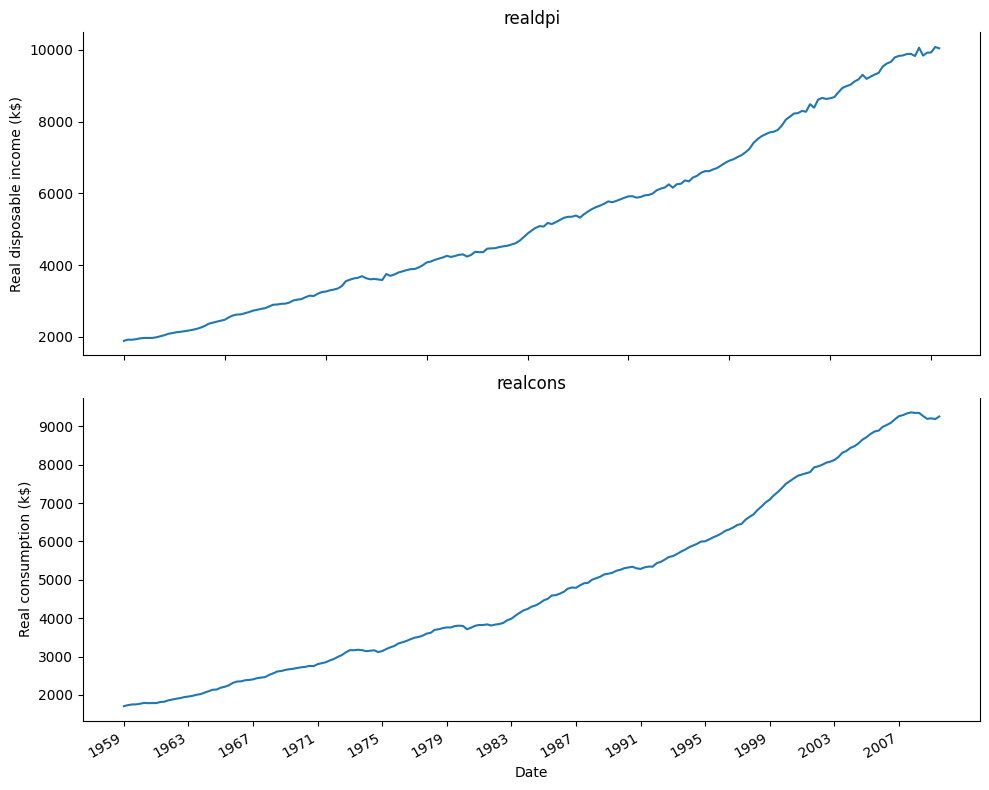

In [4]:
# 도식화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
# 정상성 테스트 -> 둘 다 비정상
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.986025351954683
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.549912338050964
p-value: 0.9976992503412904


In [6]:
# 1차 차분 및 정상성 테스트 -> 정상
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: -8.864893340673007
p-value: 1.4493606159108096e-14

---------------------

realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


In [7]:
def optimize_VARMA(endog, parameters_list):
    """
        Returns a dataframe with parameters (p,d) and corresponding AIC

        endog - the observed variable
        parameters_list - list of (p,q) tuples
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [8]:
# 타겟 정의
endog = macro_econ_data[['realdpi', 'realcons']]

# VARMA 모델은 시계열이 정상이어야 하므로, 차분된 버전을 사용하여 모델링
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

# 훈련 집합 및 테스트 집합 분할
train = endog_diff[:162]
test = endog_diff[162:]

# 가능한 p, q 범위 설정
p = range(0, 4, 1)
q = range(0, 4, 1)

# 고유한 (p,q) 조합 목록 생성
parameters = product(p, q)
parameters_list = list(parameters)

# 함수 실행 -> (3, 0)
result_df_VARMA = optimize_VARMA(train, parameters_list)
result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 0)",3123.070078
1,"(2, 1)",3124.093819
2,"(1, 3)",3125.115606
3,"(3, 2)",3125.411714
4,"(2, 3)",3125.770971
5,"(1, 2)",3126.915955
6,"(3, 1)",3129.026732
7,"(1, 1)",3129.696581
8,"(2, 2)",3129.938119
9,"(2, 0)",3130.091668


In [9]:
# 그레인저 인과관계 테스트 -> p값이 0.05보다 작으므로 귀무가설을 기각 -> 양방향 인과관계 -> 모델 유효
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


In [10]:
# 모델 피팅
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Wed, 16 Apr 2025   BIC                           3175.559
Time:                             11:26:51   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

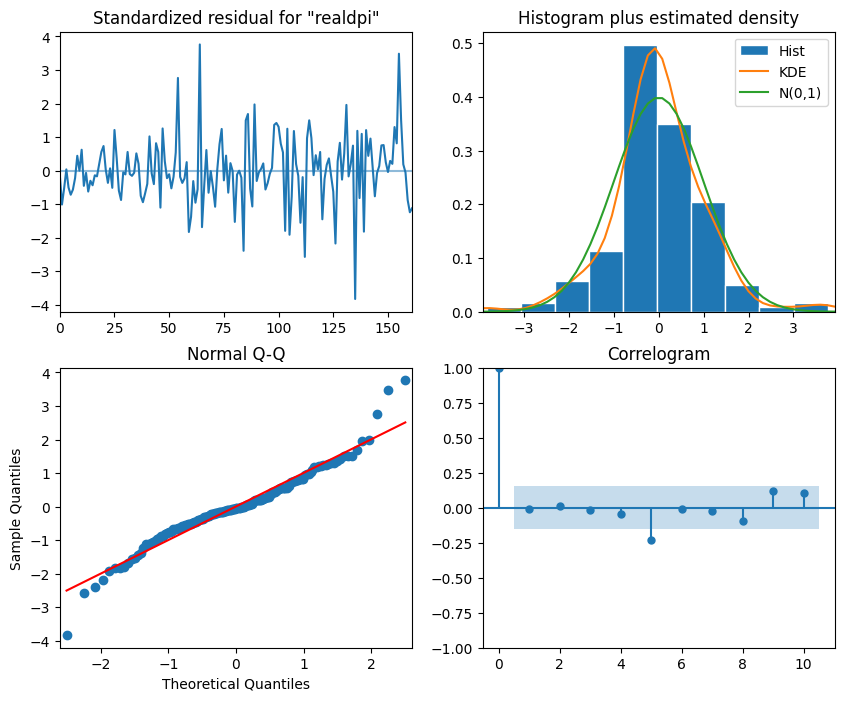

In [11]:
# realdpi 잔차 분석
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

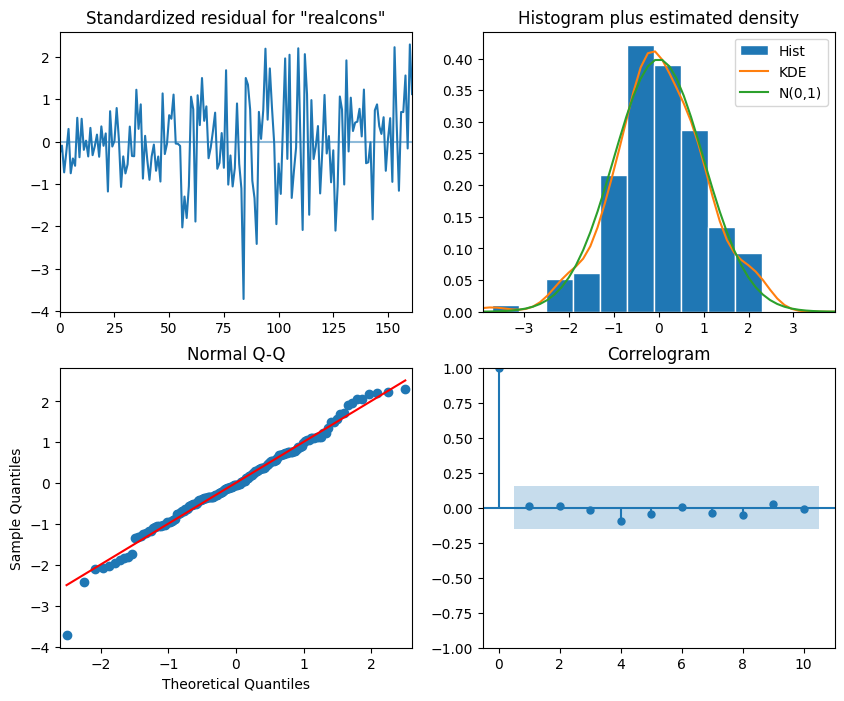

In [12]:
# realcons 잔차 분석
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [13]:
# realgdp 융-박스 테스트
realgdp_residuals = best_model_fit.resid['realdpi']

lbvalue, pvalue = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [14]:
# realcons 융-박스 테스트
realcons_residuals = best_model_fit.resid['realcons']

lbvalue, pvalue = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [15]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'VARMA':

        realdpi_pred_VARMA = []
        realcons_pred_VARMA = []

        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)

            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']

            realdpi_pred_VARMA.extend(oos_pred_realdpi)
            realcons_pred_VARMA.extend(oos_pred_realcons)

        return realdpi_pred_VARMA, realcons_pred_VARMA

    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []

        for i in range(train_len, total_len, window):

            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']

            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))

        return realdpi_pred_last, realcons_pred_last

In [16]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4 # 4단계 윈도우

realdpi_pred_VARMA, realcons_pred_VARMA = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMA')

In [41]:
# 차분된 VARMA 예측값을 누적합해 원래 값으로 복원 후 테스트셋에 저장
test = endog[163:]

test['realdpi_pred_VARMA'] = pd.Series()
test['realdpi_pred_VARMA'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMA)

test['realcons_pred_VARMA'] = pd.Series()
test['realcons_pred_VARMA'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMA)

In [18]:
# 마지막 값 예측 수행
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

In [19]:
test.head()

,realdpi,realcons,realdpi_pred_VARMA,realcons_pred_VARMA,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.224539,7354.326623,7716.0,7199.9
164,8053.4,7501.3,7897.189061,7430.258712,7716.0,7199.9
165,8135.9,7571.8,7960.563400,7496.633762,7716.0,7199.9
166,8222.3,7645.9,8014.757620,7556.621097,7716.0,7199.9
167,8234.6,7713.5,8080.700920,7631.009720,8135.9,7571.8


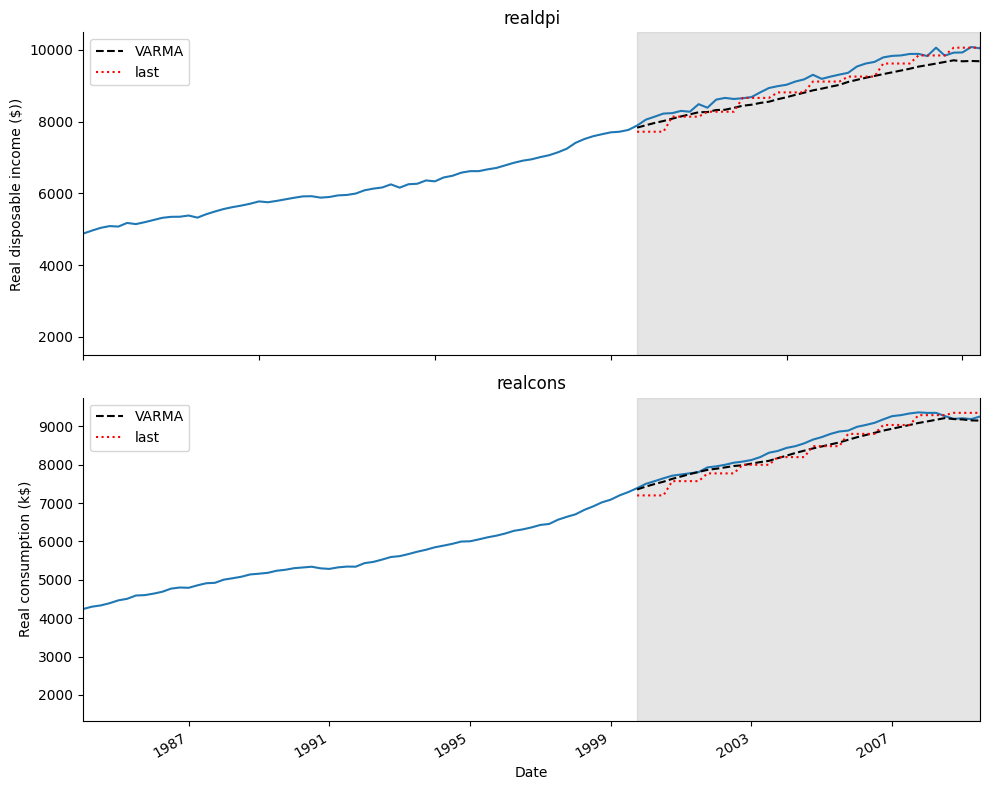

In [20]:
# 예측 결과 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VARMA'], 'k--', label='VARMA')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VARMA'], 'k--', label='VARMA')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

In [21]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
# MAPE 계산
mape_realdpi_VARMA = mape(test['realdpi'], test['realdpi_pred_VARMA'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMA = mape(test['realcons'], test['realcons_pred_VARMA'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

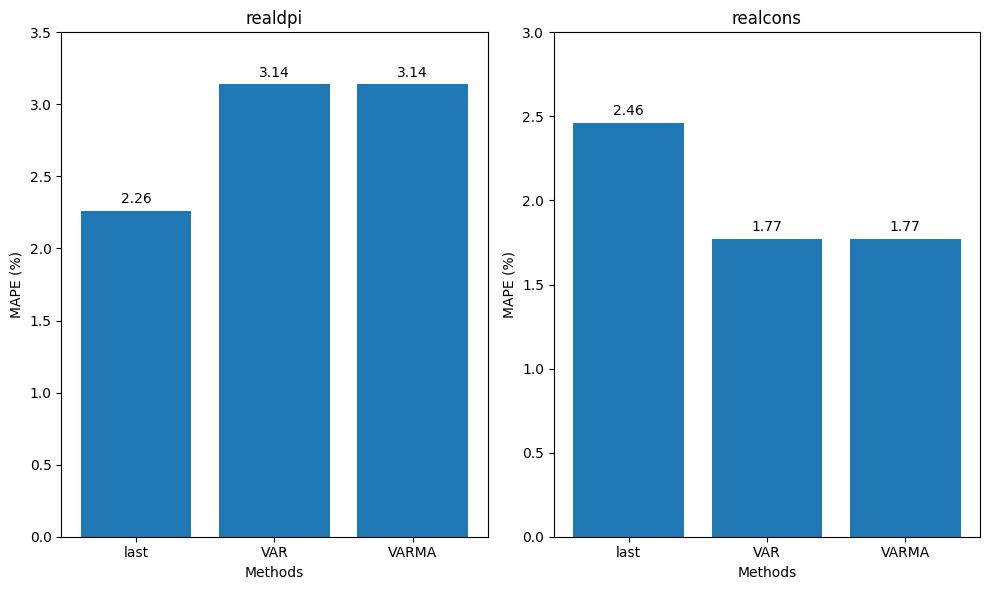

In [23]:
# 시각화
# realdpi -> 마지막 값
# realcons -> VAR(3)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR', 'VARMA']
y1 = [mape_realdpi_last, 3.14, mape_realdpi_VARMA]    # From chapter 10, VAR model achieved a MAPE of 3.14%
y2 = [mape_realcons_last, 1.77, mape_realcons_VARMA]  # From chapter 10, VAR model achieved a MAPE of 1.77%

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

# 10.5.2 VARMAX 모델을 사용하여 realdpi와 realcons 예측하기

In [24]:
def optimize_VARMAX(endog, exog, parameters_list):
    """
        Returns a dataframe with (p,q) and AIC

        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list of (p,q) tuples
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, exog, order=param).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [25]:
# 타겟 정의
endog = macro_econ_data[['realdpi', 'realcons']]

# VARMA 모델은 시계열이 정상이어야 하므로, 차분된 버전을 사용하여 모델링
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

# 외생 변수 선택: 반드시 정상일 필요는 없음
exog_cols = macro_econ_data.columns.drop(['year', 'quarter', 'realdpi', 'realcons'])

exog = macro_econ_data[exog_cols][1:163]

# 훈련 집합 및 테스트 집합 분할
train = endog_diff[:162]
test = endog_diff[162:]

# 가능한 p, q 범위 설정
p = range(0, 4, 1)
q = range(0, 4, 1)

# 고유한 (p,q) 조합 목록 생성
parameters = product(p, q)
parameters_list = list(parameters)

# 함수 실행 -> (1, 0)
result_df_VARMAX = optimize_VARMAX(train, exog, parameters_list)
result_df_VARMAX

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 0)",3113.465986
1,"(0, 1)",3117.326734
2,"(2, 0)",3118.688860
3,"(1, 1)",3119.158963
4,"(3, 0)",3121.521262
5,"(0, 3)",3122.398466
6,"(0, 2)",3122.758519
7,"(1, 2)",3125.051544
8,"(2, 1)",3125.652019
9,"(1, 3)",3127.566148


In [40]:
# 그레인저 인과관계 테스트 -> p값이 0.05보다 작으므로 귀무가설을 기각 -> 양방향 인과관계 -> 모델 유효
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [1])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [1])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=35.3881 , p=0.0000  , df=1
likelihood ratio test: chi2=32.5962 , p=0.0000  , df=1
parameter F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=7.8540  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7045  , p=0.0055  , df=1
parameter F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1


In [27]:
# 모델 피팅
best_model = VARMAX(train, exog, order=(1,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                             VARX(1)   Log Likelihood               -1527.733
                               + intercept   AIC                           3113.466
Date:                     Wed, 16 Apr 2025   BIC                           3203.006
Time:                             11:30:53   HQIC                          3149.821
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.08, 0.29   Jarque-Bera (JB):         40.79, 18.63
Prob(Q):                        0.78, 0.59   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         5.80, 2.63   Skew:                      0.12

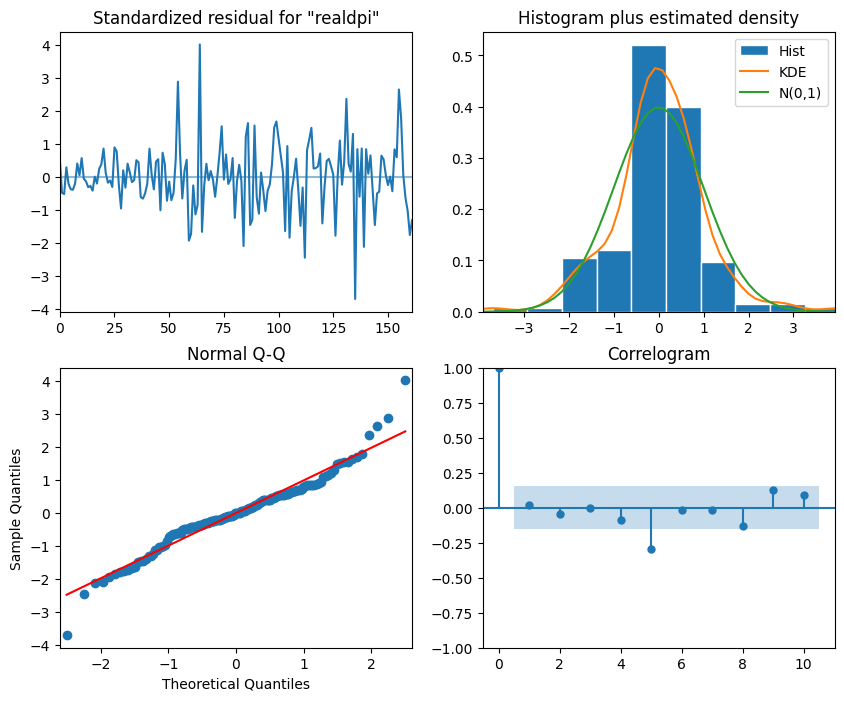

In [28]:
# realdpi 잔차 분석
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

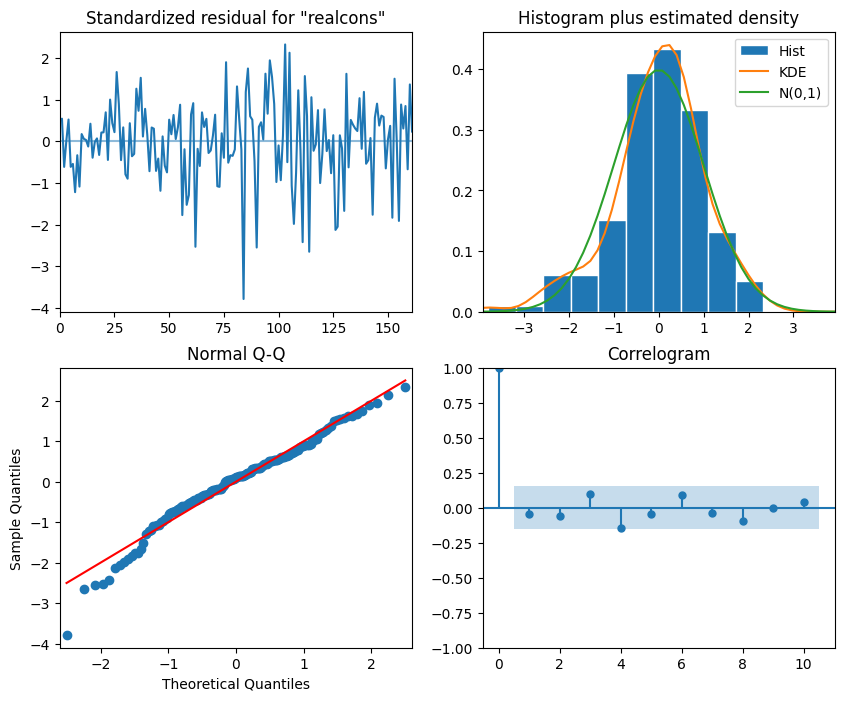

In [29]:
# realcons 잔차 분석
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [30]:
# realgdp 융-박스 테스트
realgdp_residuals = best_model_fit.resid['realdpi']

lbvalue, pvalue = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [31]:
# realcons 융-박스 테스트
realcons_residuals = best_model_fit.resid['realcons']

lbvalue, pvalue = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [32]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'VARMAX':

        realdpi_pred_VARMAX = []
        realcons_pred_VARMAX = []

        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], exog[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1, exog=exog.iloc[-1])    # Use the exogenous variable to
                                                                                       # generate predictions

            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']

            realdpi_pred_VARMAX.extend(oos_pred_realdpi)
            realcons_pred_VARMAX.extend(oos_pred_realcons)

        return realdpi_pred_VARMAX, realcons_pred_VARMAX

    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []

        for i in range(train_len, total_len, window):

            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']

            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))

        return realdpi_pred_last, realcons_pred_last

In [33]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1    # We can only predict the next timestep, since we have exogenous variables (just like the SARIMAX model)

exog = macro_econ_data[exog_cols][1:]

realdpi_pred_VARMAX, realcons_pred_VARMAX = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')

In [34]:
# 차분된 VARMAX 예측값을 누적합해 원래 값으로 복원 후 테스트셋에 저장
test = endog[163:]

test['realdpi_pred_VARMAX'] = pd.Series()
test['realdpi_pred_VARMAX'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMAX)

test['realcons_pred_VARMAX'] = pd.Series()
test['realcons_pred_VARMAX'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMAX)

In [35]:
# 마지막 값 예측 수행
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

In [36]:
test.head()

,realdpi,realcons,realdpi_pred_VARMAX,realcons_pred_VARMAX,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7785.091732,7409.320799,7716.0,7199.9
164,8053.4,7501.3,7822.256937,7547.735705,7765.9,7286.4
165,8135.9,7571.8,7865.562694,7684.481440,7887.7,7389.2
166,8222.3,7645.9,7901.100381,7813.278233,8053.4,7501.3
167,8234.6,7713.5,7940.825543,7940.689009,8135.9,7571.8


In [37]:
# MAPE 계산
mape_realdpi_VARMAX = mape(test['realdpi'], test['realdpi_pred_VARMAX'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMAX = mape(test['realcons'], test['realcons_pred_VARMAX'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

In [38]:
print(mape_realdpi_VARMAX)

11.266610423336424


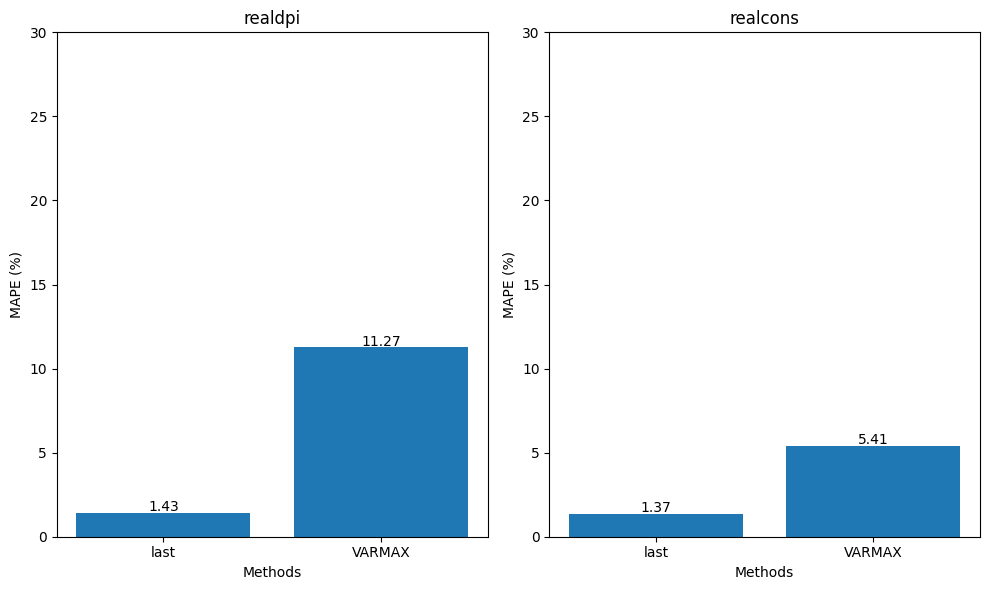

In [39]:
# 시각화
# realdpi -> VARMAX
# realcons -> VARMAX
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VARMAX']
y1 = [mape_realdpi_last, mape_realdpi_VARMAX]
y2 = [mape_realcons_last, mape_realcons_VARMAX]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 30)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 30)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

plt.tight_layout()